In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from imblearn.over_sampling import RandomOverSampler
from category_encoders import TargetEncoder
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,recall_score,auc,classification_report,roc_curve

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from tqdm import tqdm
from xgboost import XGBClassifier

pd.set_option("display.max_columns",None)

In [2]:
os.getcwd()

'C:\\Users\\krist\\Desktop\\5291  Advanced DS\\ADA-Project\\doc'

### 1.Loading cleaned data

In [4]:
df = pd.read_csv("../data/Train_Dataset.csv")

df = df.drop(["Own_House_Age","Social_Circle_Default","Score_Source_1"],axis=1)


C:\Users\krist\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,7,8,16,17,18,19,20,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
modify_to_float = ['Client_Income','Credit_Amount', 'Loan_Annuity','Population_Region_Relative',
                    'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days','Score_Source_2',
                    "Score_Source_3"]
for col in modify_to_float:
    df[col] = pd.to_numeric(df[col], errors='coerce')

cat_col = []
num_col = []

for col in df:
    if df[col].dtype == object:
        cat_col.append(col)
    elif col not in ["ID","Default"]:
        num_col.append(col)

def fill(dataset):
    for col in cat_col:
        dataset[col] = dataset[col].fillna("Missing")
    for col in num_col:
        fillvalue = dataset[col].median()
        dataset[col] = dataset[col].fillna(fillvalue)
    return dataset

features,target = df.drop(["ID","Default"],axis=1),df.Default
X_train_raw,X_test_raw,y_train,y_test = train_test_split(features,target,stratify=target,test_size=0.2,random_state=1235)
X_train = fill(X_train_raw)
X_test = fill(X_test_raw)


In [6]:
X_train

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau
102698,10350.0,0.0,1.0,0.0,0.0,0.0,38404.80,1177.20,Alone,Commercial,Graduation dropout,D,Male,CL,Home,0.018850,14680.0,599.0,385.0,5118.0,1,1,0,Missing,1.0,2.0,4.0,12.0,No,Yes,Other,0.641058,0.045677,1103.0,2.0
9309,22500.0,1.0,1.0,1.0,0.0,0.0,222025.95,5869.80,Alone,Missing,Graduation,S,Female,CL,Home,0.018029,16036.0,2077.0,7262.0,4625.0,1,0,0,Laborers,1.0,2.0,3.0,7.0,Yes,Yes,Missing,0.350701,0.565608,11.0,0.0
68984,12600.0,1.0,1.0,0.0,1.0,0.0,51750.00,1944.90,Alone,Service,Secondary,D,Male,CL,Home,0.025164,13824.0,1222.0,8441.0,1354.0,1,0,1,Sales,1.0,2.0,4.0,11.0,Yes,Yes,Self-employed,0.064164,0.538863,390.0,0.0
109496,9000.0,0.0,1.0,0.0,0.0,2.0,27000.00,1826.55,Relative,Govt Job,Graduation,M,Male,CL,Home,0.003069,13016.0,4046.0,7092.0,2073.0,1,0,0,Core,4.0,3.0,6.0,11.0,Yes,Yes,Other,0.734533,0.614414,2284.0,0.0
68021,18000.0,0.0,0.0,0.0,0.0,1.0,18000.00,900.00,Alone,Service,Secondary,D,Female,RL,Home,0.018850,13263.0,1155.0,7278.0,4051.0,1,0,0,Security,2.0,2.0,2.0,15.0,Yes,Yes,Security,0.564623,0.513694,1308.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104810,13500.0,0.0,1.0,1.0,1.0,0.0,30220.65,1344.15,Alone,Commercial,Secondary,D,Male,CL,Missing,0.019101,16621.0,500.0,8179.0,184.0,1,0,0,Sales,1.0,2.0,6.0,9.0,Yes,Yes,Self-employed,0.082918,0.236611,872.0,6.0
115269,9000.0,0.0,0.0,0.0,0.0,0.0,26955.00,1154.70,Alone,Retired,Secondary,D,Male,CL,Home,0.020246,21854.0,365243.0,1178.0,4943.0,1,0,0,Missing,1.0,3.0,3.0,11.0,Yes,Yes,XNA,0.034349,0.528093,1344.0,1.0
20053,15750.0,1.0,1.0,1.0,0.0,0.0,90000.00,2499.75,Alone,Service,Graduation,M,Male,CL,Home,0.046220,10337.0,651.0,4995.0,3010.0,1,0,0,Core,2.0,1.0,3.0,19.0,Yes,Yes,Other,0.650924,0.639708,505.0,2.0
31,22500.0,0.0,0.0,0.0,1.0,0.0,43787.70,2248.65,Alone,Service,Secondary,M,Missing,CL,Home,0.007330,20353.0,6904.0,6212.0,558.0,1,0,0,Core,2.0,2.0,0.0,13.0,Yes,Yes,Kindergarten,0.725361,0.332851,1877.0,9.0


In [7]:
def prepocessing(X_train,y_train,X_test,y_test):
    for col in cat_col:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        
    for col in cat_col: 
        te = TargetEncoder()
        X_train[col] = te.fit_transform(X_train[col], y_train)
        X_test[col] = te.transform(X_test[col],y_test)
    
    se = StandardScaler()
    X_train = se.fit_transform(X_train)
    X_test = se.transform(X_test)
                
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = prepocessing(X_train,y_train,X_test,y_test)



In [8]:
X_train.shape

(97484, 35)

### 2.Split training data into training set and validation set 

In [ ]:
# oversample = RandomOverSampler(sampling_strategy='minority', random_state=5291)
# X_new, y_new = oversample.fit_resample(X_train, y_train)

# X_train,X_val,y_train,y_val = train_test_split(X_new,y_new,test_size=0.2,random_state=5291)

In [9]:
X_train

array([[-0.54756507, -0.70644318,  1.45266374, ..., -2.74399518,
         0.18067519,  0.13754714],
       [ 0.48304318,  1.415542  ,  1.45266374, ...,  0.28600951,
        -1.15942982, -1.00981482],
       [-0.35671169,  1.415542  ,  1.45266374, ...,  0.13014599,
        -0.69432012, -1.00981482],
       ...,
       [-0.08951696,  1.415542  ,  1.45266374, ...,  0.71783994,
        -0.55319184,  0.13754714],
       [ 0.48304318, -0.70644318, -0.68839055, ..., -1.07043169,
         1.13052984,  4.15331402],
       [-0.6620771 , -0.70644318,  1.45266374, ...,  0.16145261,
         0.90104299,  0.13754714]])

In [10]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=91)


### 3. Builging models

In [11]:
def svm(X_train,y_train,X_test,y_test):
    clf = make_pipeline(StandardScaler(),SVC(probability=True))
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,-1]
#     svm_cv = cross_val_score(clf, X_train, y_train, cv=k_fold,scoring = 'accuracy').mean()
    
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
#     print(svm_cv)

    plot_ROC(y_test,y_prob)
    return clf

In [12]:
def logistic(X_train,y_train,X_test,y_test):
    clf = LogisticRegression(penalty="l1",solver='liblinear')
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,-1]
#     logistictic_cv = cross_val_score(clf, X_train, y_train, cv=k_fold,scoring = 'accuracy').mean()
    
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
#     print(logistictic_cv)
    
    plot_ROC(y_test,y_prob)
    return clf

In [19]:
def randomforest(X_train,y_train,X_test,y_test):
    clf = RandomForestClassifier(max_depth=14,  n_estimators=500, random_state=1245,criterion="entropy")
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,-1]
#     randomforest_cv = cross_val_score(clf, X_train, y_train, cv=k_fold,scoring = 'accuracy').mean()
    
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
#     print(randomforest_cv)
    
    plot_ROC(y_test,y_prob)
    return clf

In [24]:
def xgboost(X_train,y_train,X_test,y_test):
    clf = XGBClassifier(objective= 'binary:logistic', colsample_bytree=0.7,gamma=0.1, learning_rate=0.01, 
              max_depth=12,n_estimators=700, random_state=1245)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,-1]
#     randomforest_cv = cross_val_score(clf, X_train, y_train, cv=k_fold,scoring = 'accuracy').mean()
    
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
#     print(randomforest_cv)
    
    plot_ROC(y_test,y_prob)
    return clf

In [14]:
def knn(X_train,y_train,X_test,y_test):
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,-1]
#     knn_cv = cross_val_score(clf, X_train, y_train, cv=k_fold,scoring = 'accuracy').mean()
    
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
#     print(knn_cv)
    
    plot_ROC(y_test,y_prob)
    return clf


In [15]:
def plot_ROC(y_test,y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    fig,ax = plt.subplots(figsize=(4,4),dpi=800)
    ax.grid(visible=True)
    plt.title('ROC Curve')
    ax.plot(fpr, tpr, 'b', label = 'AUC')
    ax.plot([0,1],[0,1],'--')
    ax.legend(loc = 'lower right')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    plt.show()


In [ ]:
# svm(X_train,y_train,X_val,y_val)

[[22390    13]
 [ 1952    17]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     22403
           1       0.57      0.01      0.02      1969

    accuracy                           0.92     24372
   macro avg       0.74      0.50      0.49     24372
weighted avg       0.89      0.92      0.88     24372

0.6357732688661033


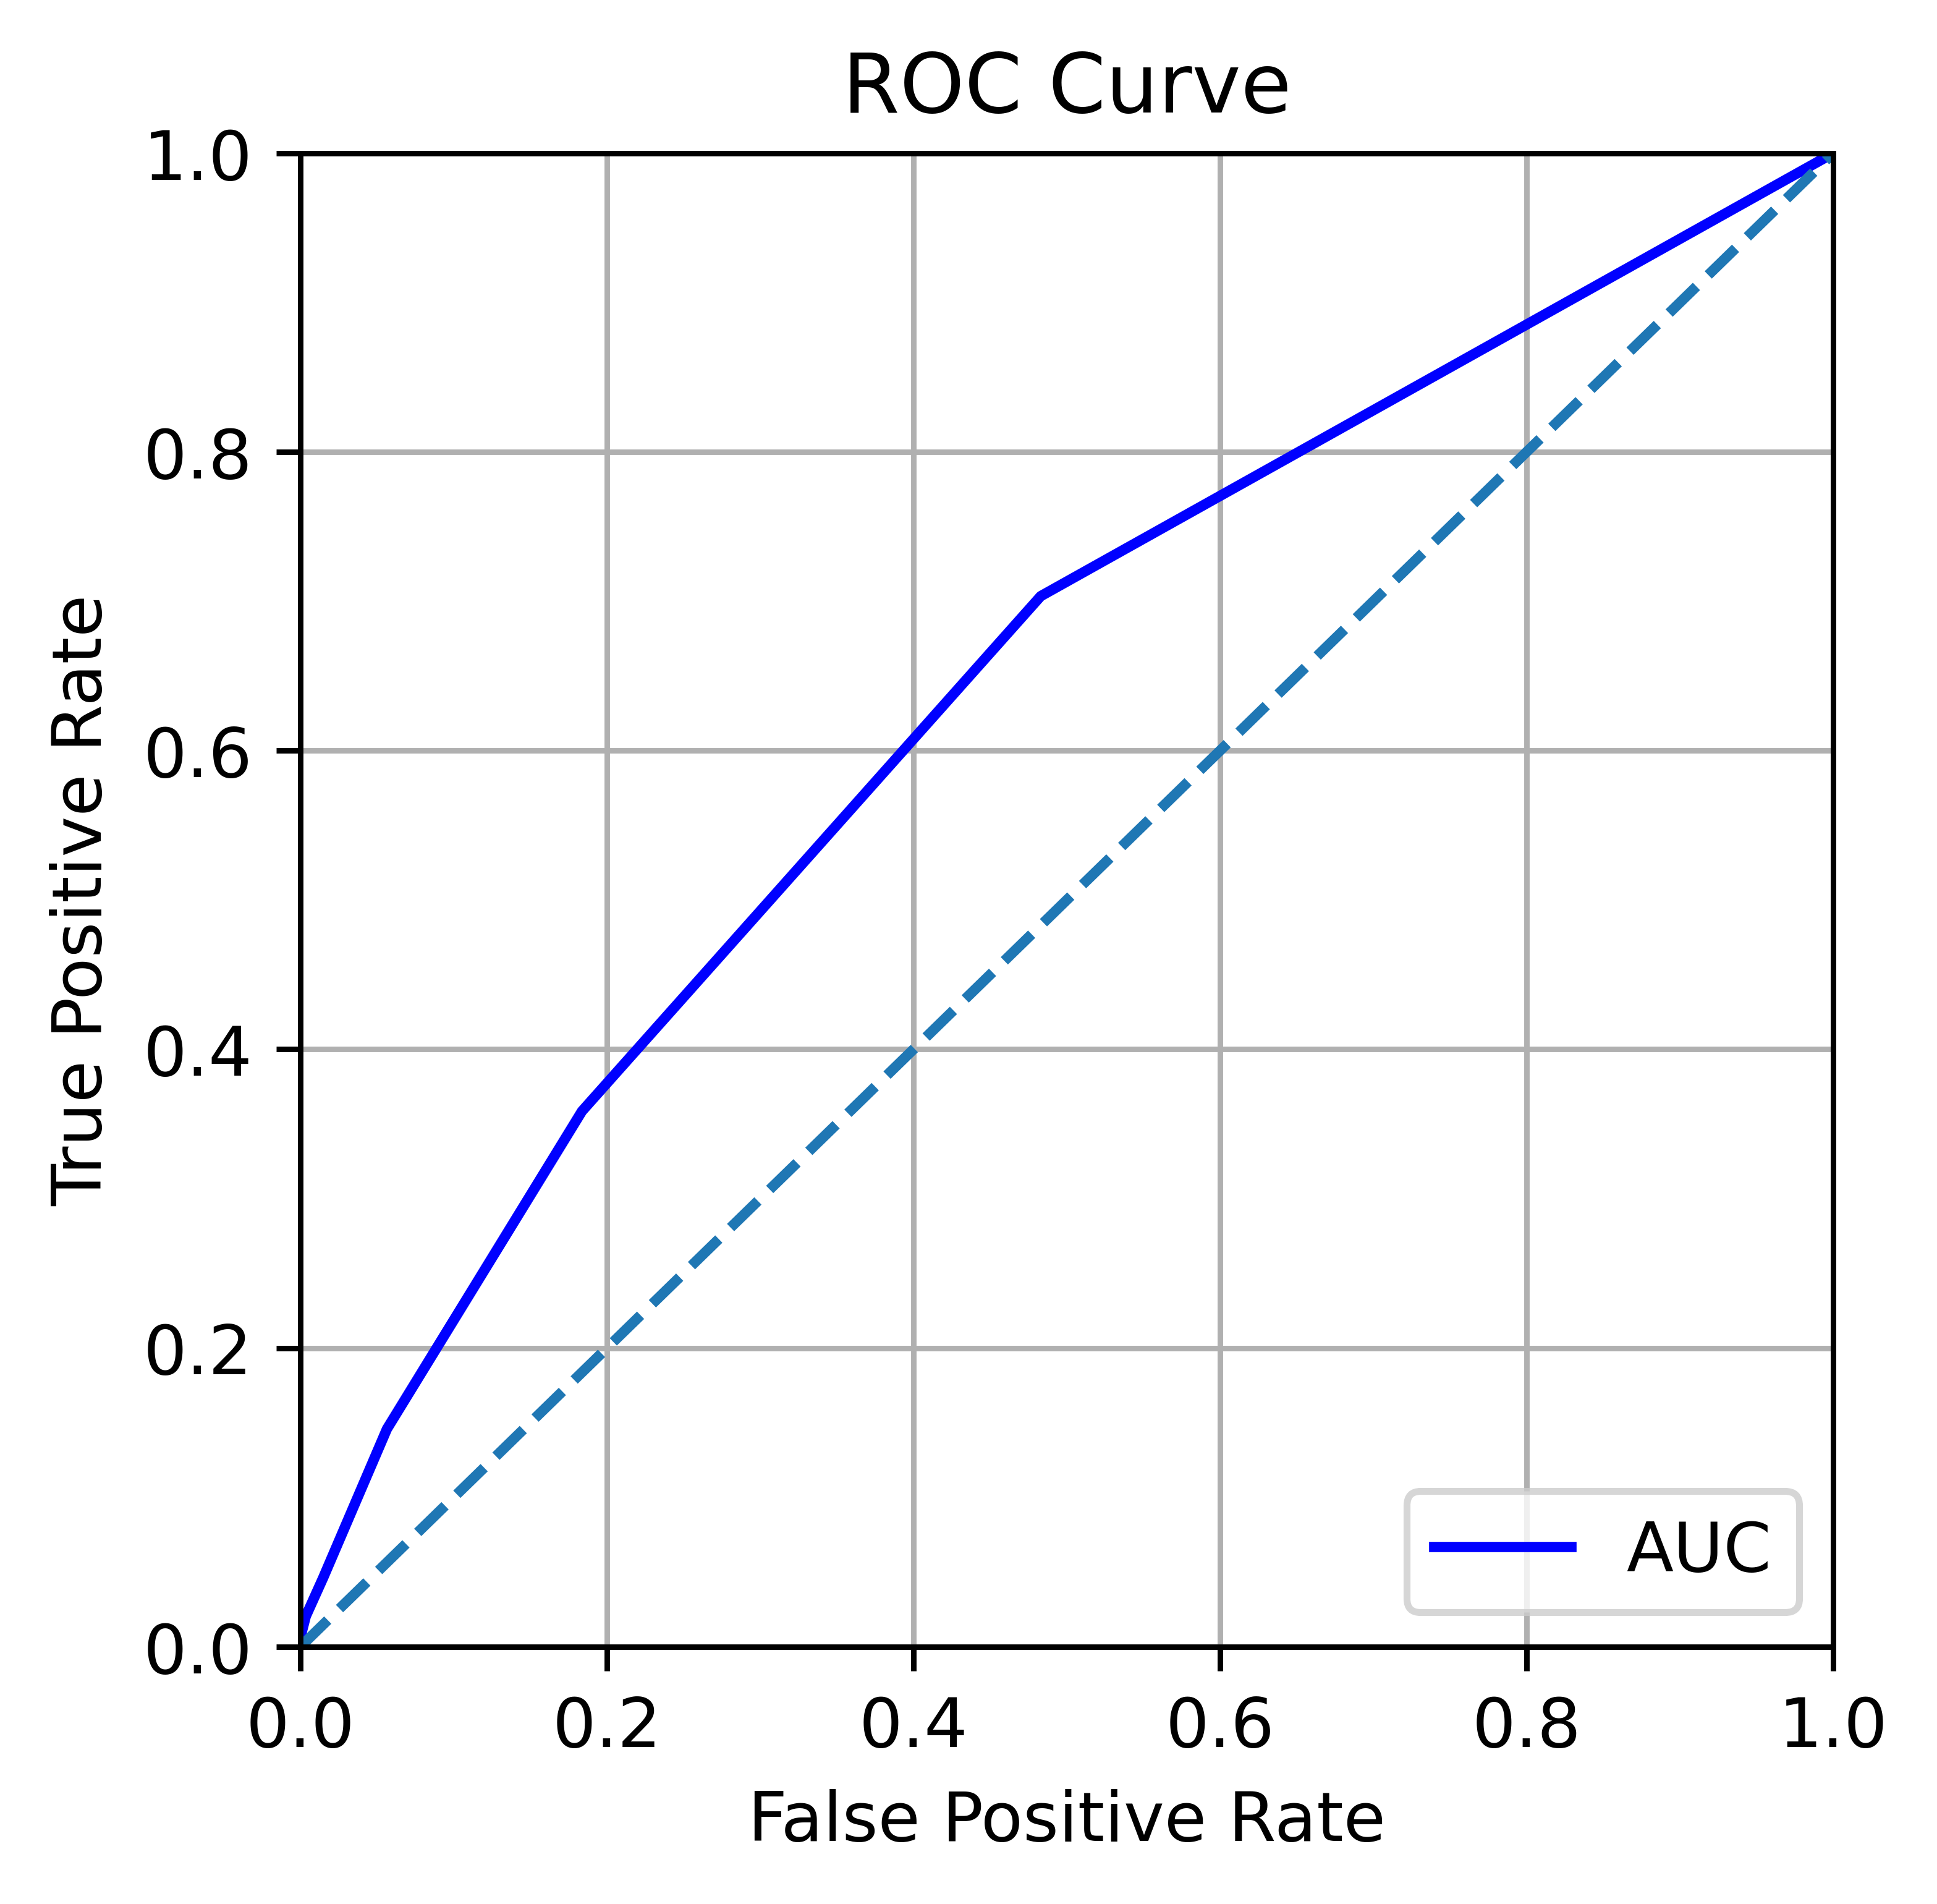

KNeighborsClassifier(n_neighbors=10)

In [16]:
knn(X_train,y_train,X_test,y_test)

[[22403     0]
 [ 1962     7]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     22403
           1       1.00      0.00      0.01      1969

    accuracy                           0.92     24372
   macro avg       0.96      0.50      0.48     24372
weighted avg       0.93      0.92      0.88     24372

0.7744693465131445


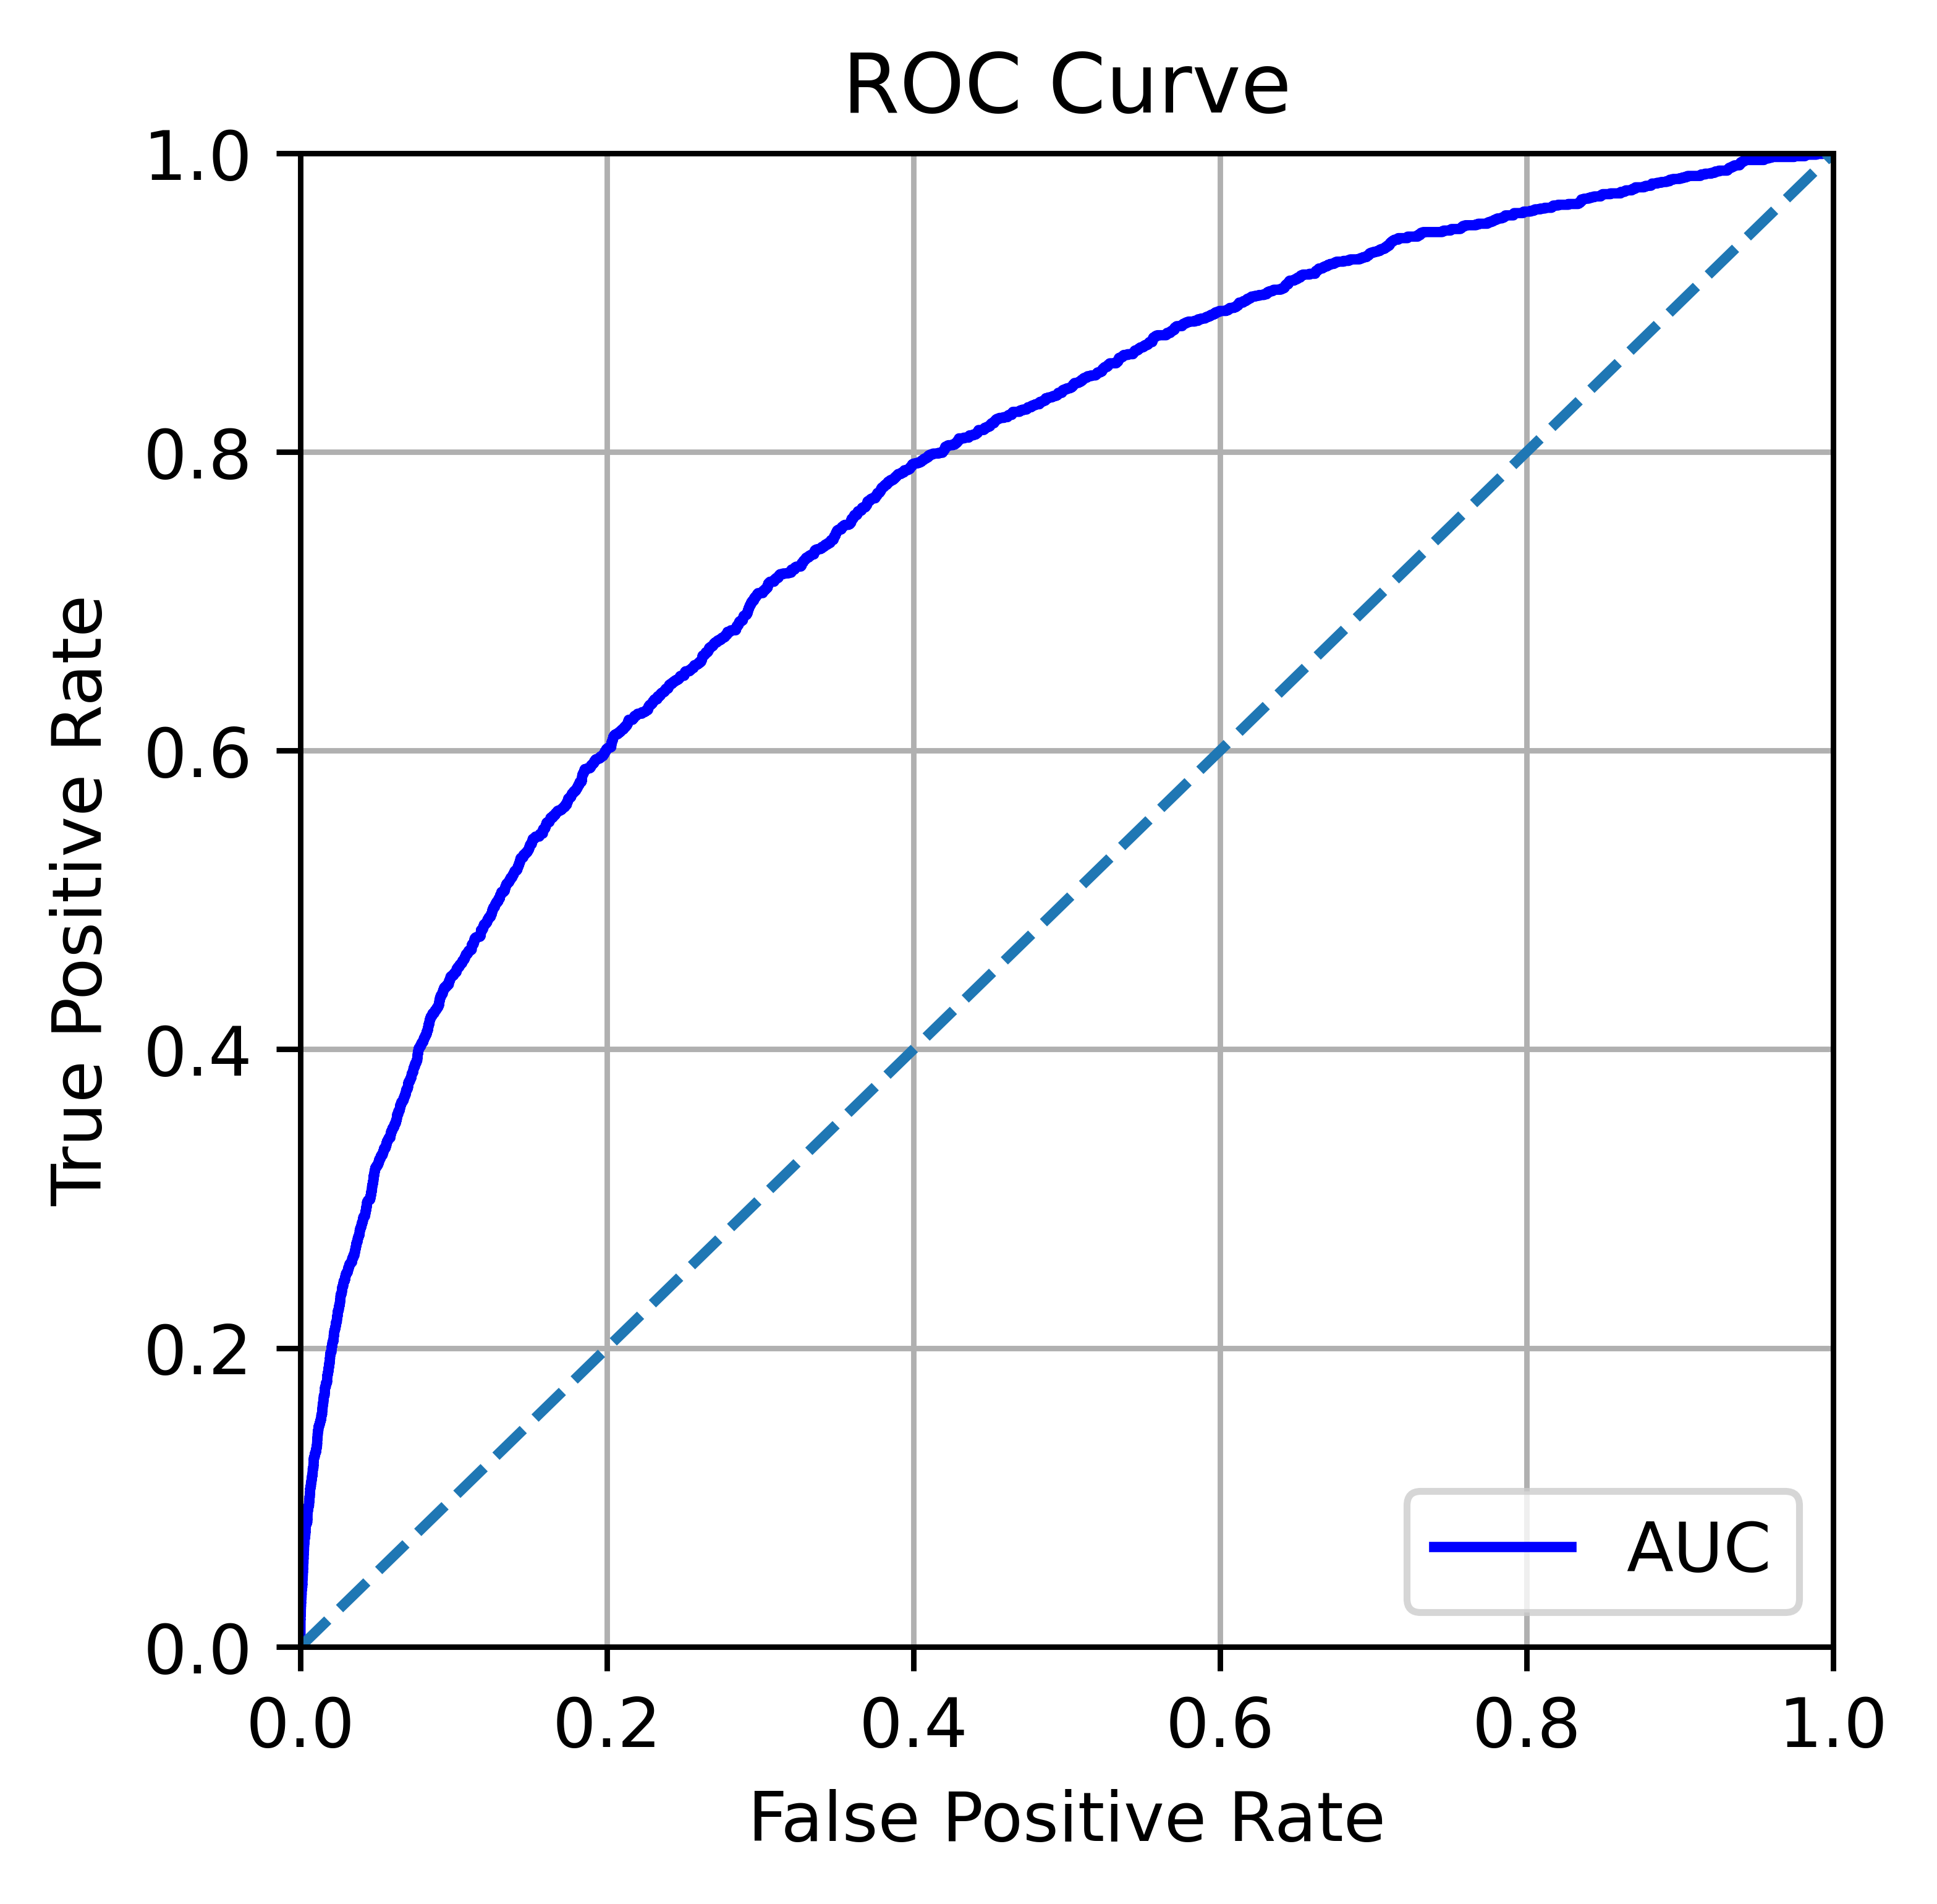

RandomForestClassifier(criterion='entropy', max_depth=14, n_estimators=500,
                       random_state=1245)

In [20]:
randomforest(X_train,y_train,X_test,y_test)

C:\Users\krist\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:56:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[22395     8]
 [ 1870    99]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     22403
           1       0.93      0.05      0.10      1969

    accuracy                           0.92     24372
   macro avg       0.92      0.52      0.53     24372
weighted avg       0.92      0.92      0.89     24372

0.777134274736975


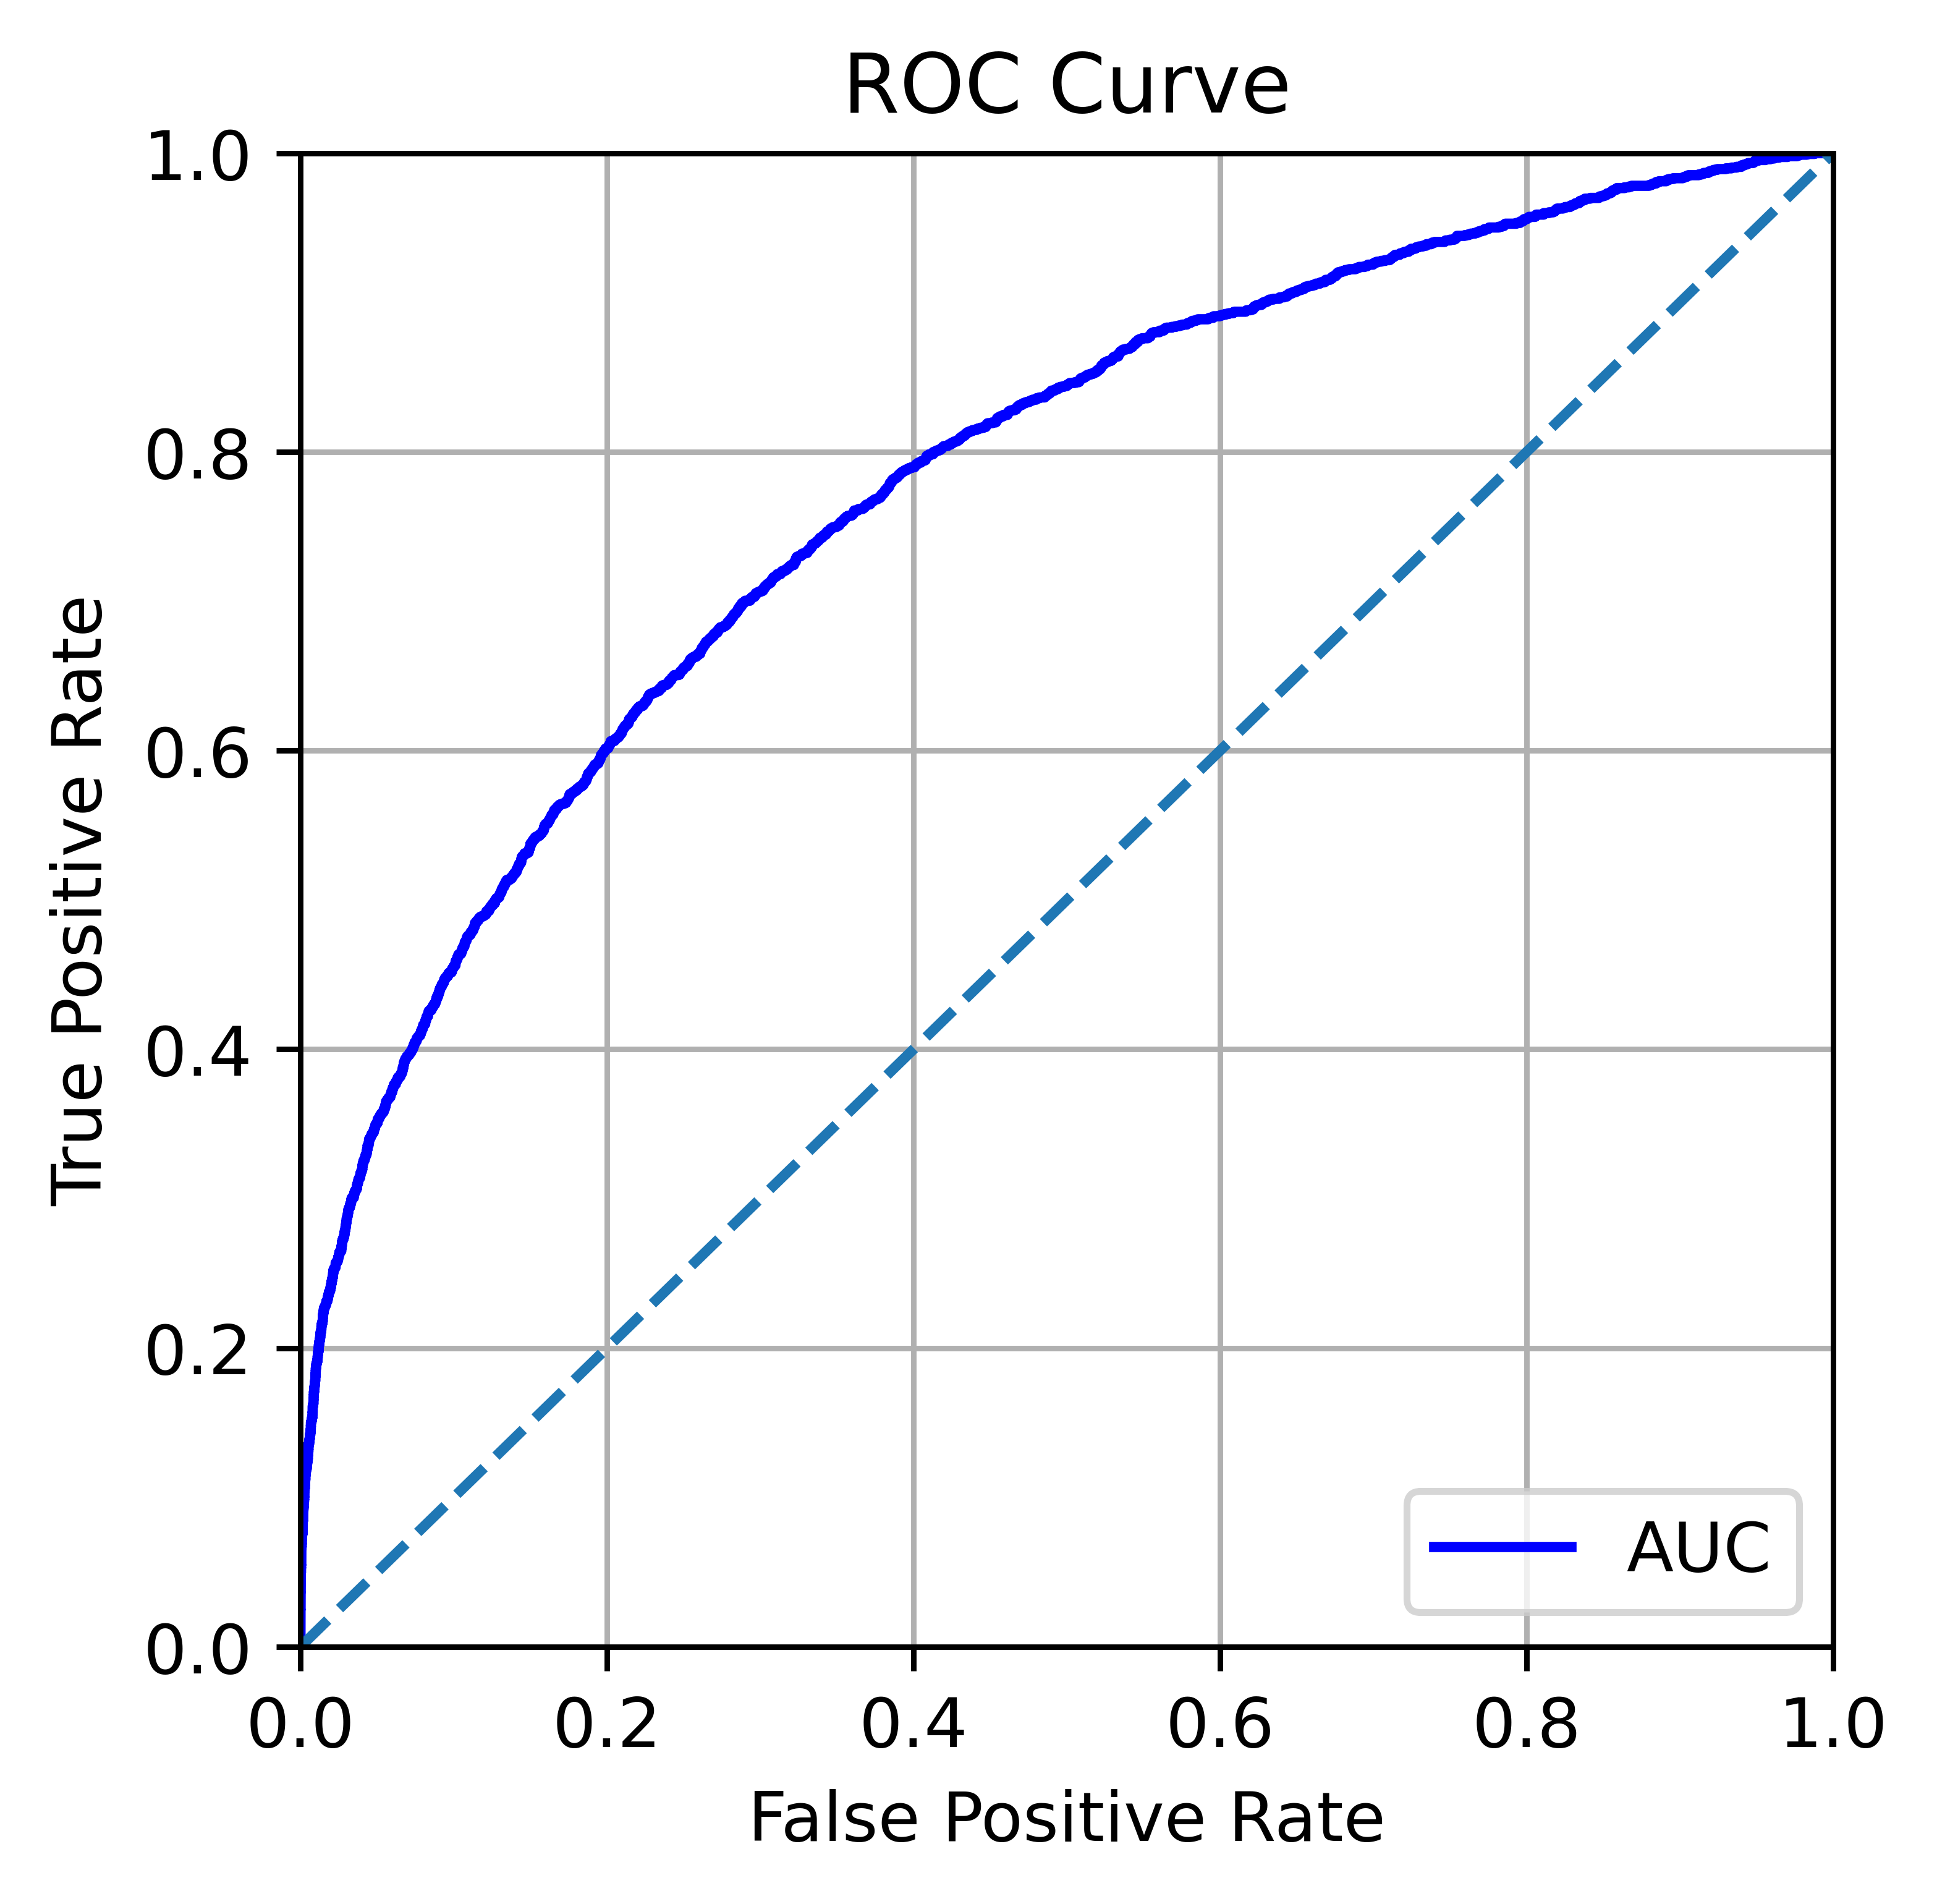

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=1245, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [25]:
xgboost(X_train,y_train,X_test,y_test)

[[22395     8]
 [ 1963     6]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     22403
           1       0.43      0.00      0.01      1969

    accuracy                           0.92     24372
   macro avg       0.67      0.50      0.48     24372
weighted avg       0.88      0.92      0.88     24372

0.7276015530369433


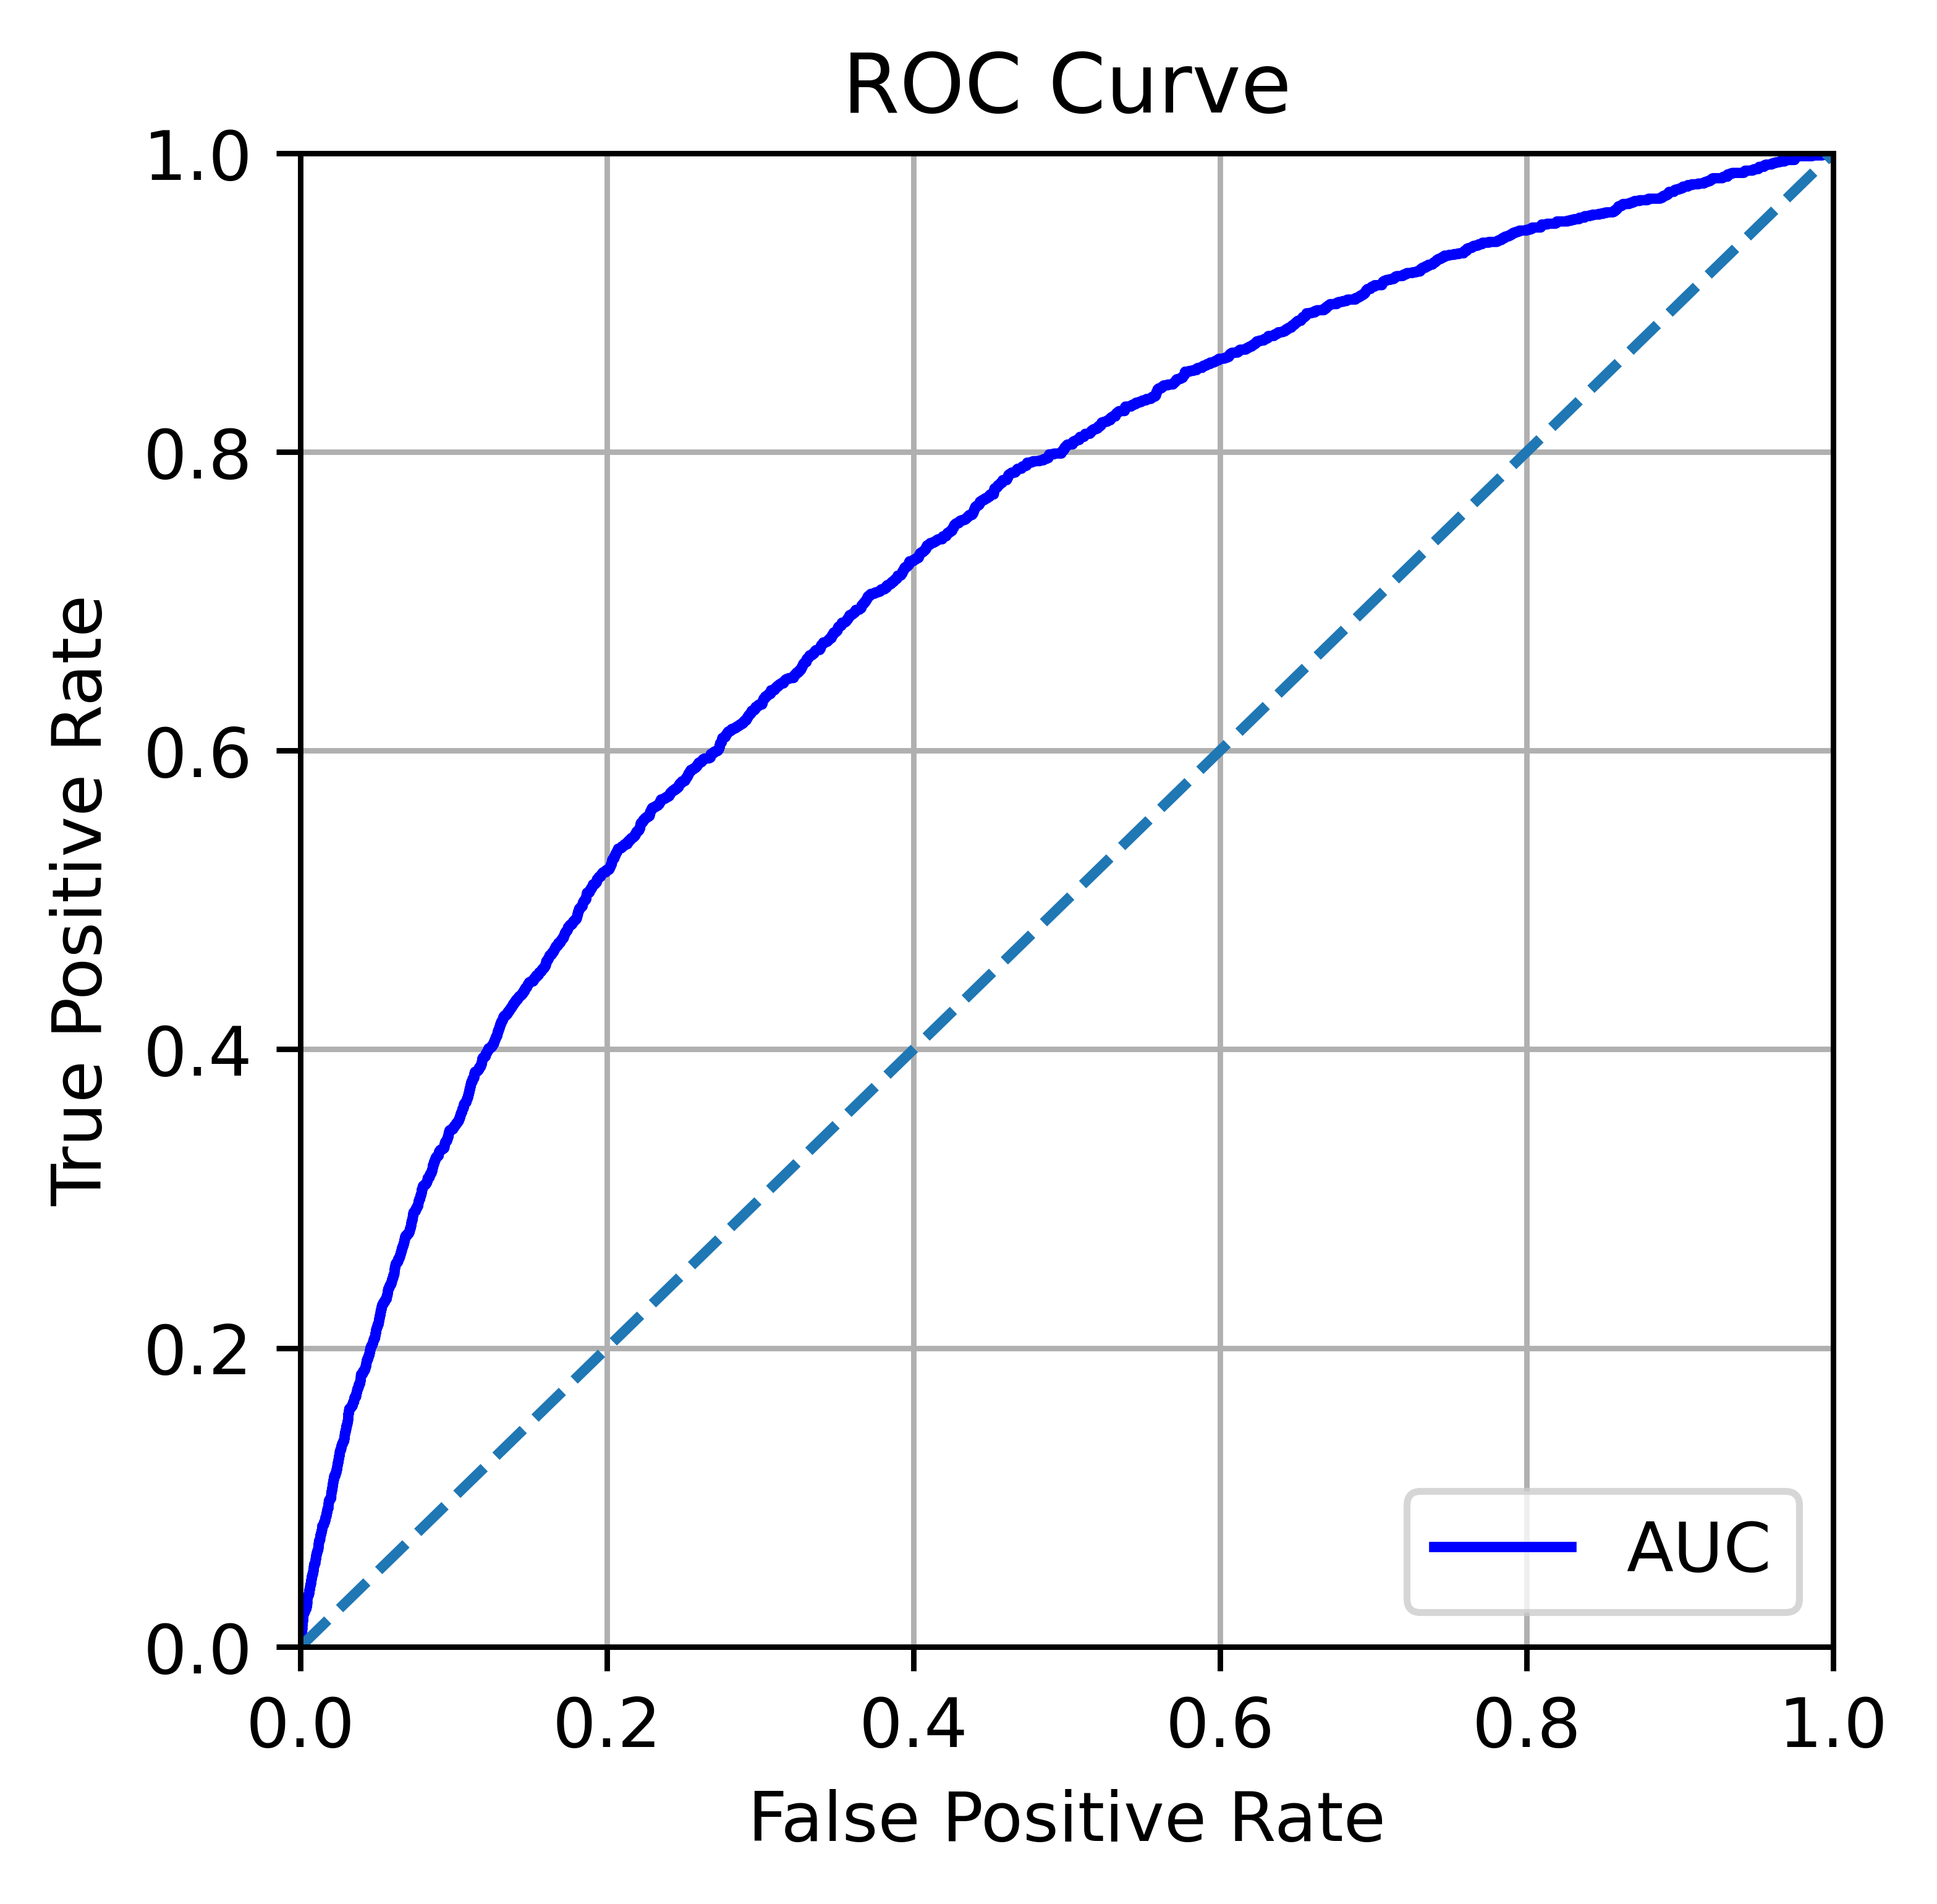

LogisticRegression(penalty='l1', solver='liblinear')

In [18]:
logistic(X_train,y_train,X_test,y_test)

### 4. Neural network

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device: {}".format(device))

X_train_raw

class DNN(nn.Module):
    def __init__(self,feature_size,hidden_layer1=128,hidden_layer2=256,dropout=0.6):
        super().__init__()
        self.feature_size = feature_size
        self.hidden_layer1 = hidden_layer1
        self.hidden_layer2 = hidden_layer2
        self.dropout = dropout
        self.dnn = nn.Sequential(
            nn.Linear(self.feature_size,self.hidden_layer1),
            nn.BatchNorm1d(self.hidden_layer1),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            
            nn.Linear(self.hidden_layer1,self.hidden_layer2),
            nn.BatchNorm1d(self.hidden_layer2),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            
            nn.Linear(self.hidden_layer2,2)
        ) 
        
    def forward(self,x):
        x = self.dnn(x)
        return x
    


Current device: cpu


In [27]:
class Defaultdataset(Dataset):
    def __init__(self,X_train,y_train):
        self.X = torch.tensor(X_train)
        self.y = torch.tensor(y_train.to_numpy())
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx,], self.y[idx]

In [28]:
epoch = 10
batch_size = 256
loss = nn.CrossEntropyLoss(weight=torch.tensor([1.,5.]))
model = DNN(X_train.shape[1],256,64,0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0005)

train_set = DataLoader(Defaultdataset(X_train,y_train),batch_size=batch_size,shuffle=True)
validation_set = DataLoader(Defaultdataset(X_test,y_test),batch_size=batch_size)

In [29]:
def train_model(train_set,validation_set,model,epoch,batch_size,loss,optimizer):
    print("Training on {}".format(device))
    for i in range(epoch):
        model.train()
        train_loss, train_acc, n = 0,0,0
        for X,y in train_set:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_hat = model(X.float())
            l = loss(y_hat,y).sum()
            l.backward()
            optimizer.step()
            
            train_loss += l.item()
            train_acc += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_loss,test_acc = evaluation(model,validation_set)
        print('epoch {}, train loss {:.6f}, train accuracy {:.6f}, test loss {:.6f}, test accuracy {:.6f}'
              .format(i + 1, train_loss / n, train_acc/ n, test_loss, test_acc))    
        

In [30]:
def evaluation(model,validation_set):
    val_loss,val_acc,n = 0,0,0
    model.eval()
    with torch.no_grad():
        for X,y in validation_set:
            y_hat = model(X.float())
            l = loss(y_hat,y).sum()
                
            val_loss += l.item()
            val_acc += (y_hat.argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return val_loss/n, val_acc/n

In [31]:
train_model(train_set,validation_set,model,epoch,batch_size,loss,optimizer)


Training on cpu
epoch 1, train loss 0.002366, train accuracy 0.814934, test loss 0.002200, test accuracy 0.852536
epoch 2, train loss 0.002220, train accuracy 0.867660, test loss 0.002176, test accuracy 0.854013
epoch 3, train loss 0.002192, train accuracy 0.866532, test loss 0.002161, test accuracy 0.859716
epoch 4, train loss 0.002173, train accuracy 0.866347, test loss 0.002149, test accuracy 0.869071
epoch 5, train loss 0.002161, train accuracy 0.866542, test loss 0.002145, test accuracy 0.876703
epoch 6, train loss 0.002159, train accuracy 0.865639, test loss 0.002138, test accuracy 0.857911
epoch 7, train loss 0.002149, train accuracy 0.864039, test loss 0.002158, test accuracy 0.905506
epoch 8, train loss 0.002137, train accuracy 0.863947, test loss 0.002130, test accuracy 0.861439
epoch 9, train loss 0.002139, train accuracy 0.865588, test loss 0.002128, test accuracy 0.862793
epoch 10, train loss 0.002136, train accuracy 0.864049, test loss 0.002127, test accuracy 0.853028


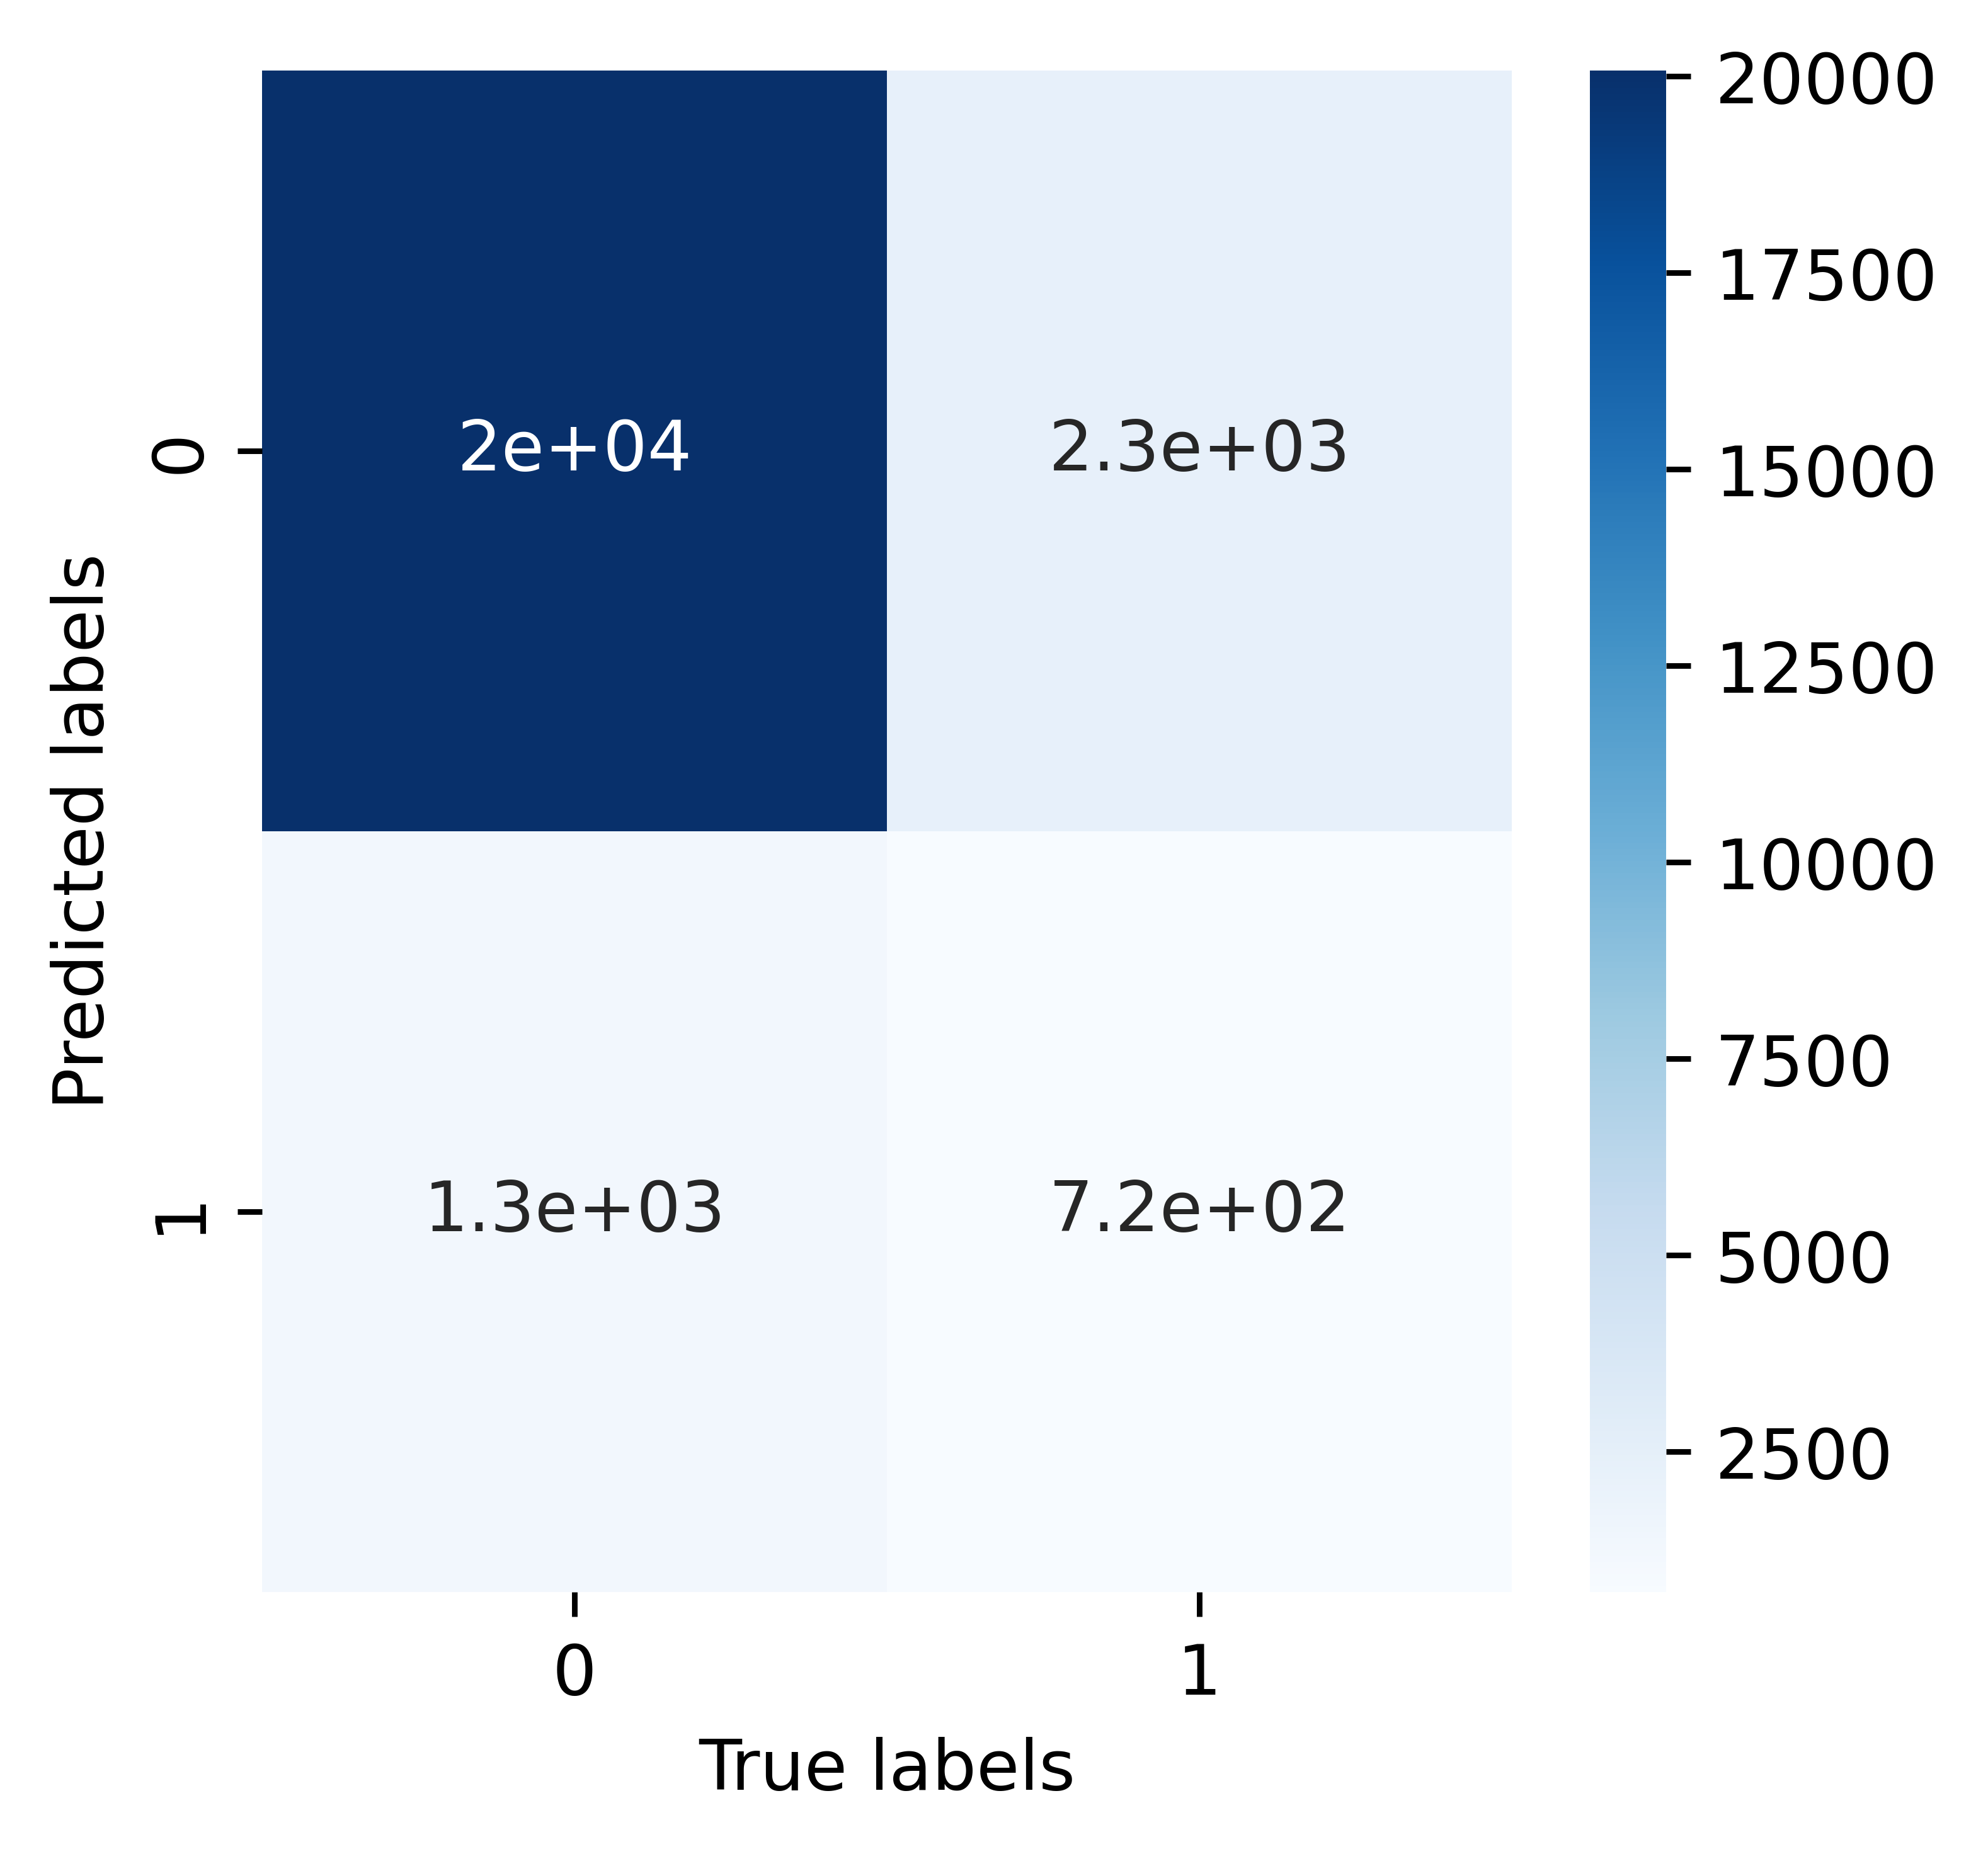

[[20074  2329]
 [ 1253   716]]
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     22403
         1.0       0.24      0.36      0.29      1969

    accuracy                           0.85     24372
   macro avg       0.59      0.63      0.60     24372
weighted avg       0.88      0.85      0.87     24372

0.7267368920313695


In [32]:
y_true = torch.tensor([])
y_prob = torch.tensor([])
y_pred = torch.tensor([])
for X,y in validation_set:
    y_hat = model(X.float())
    
    y_true = torch.cat((y_true,y))
    y_prob = torch.cat((y_prob,y_hat[:,1]))
    y_pred = torch.cat((y_pred,y_hat.argmax(dim=1)))
    
confusion_mtx = confusion_matrix(y_true,y_pred)
fig,ax = plt.subplots(figsize=(4,4),dpi=800)
sns.heatmap(confusion_mtx, xticklabels=list(['0','1']), yticklabels=list(['0','1']),annot=True, cmap='Blues')
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')
plt.show()

print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

y_prob = y_prob.detach().numpy()
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
print(roc_auc)

[[22395     8]
 [ 1963     6]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     22403
           1       0.43      0.00      0.01      1969

    accuracy                           0.92     24372
   macro avg       0.67      0.50      0.48     24372
weighted avg       0.88      0.92      0.88     24372

0.7276009862914001


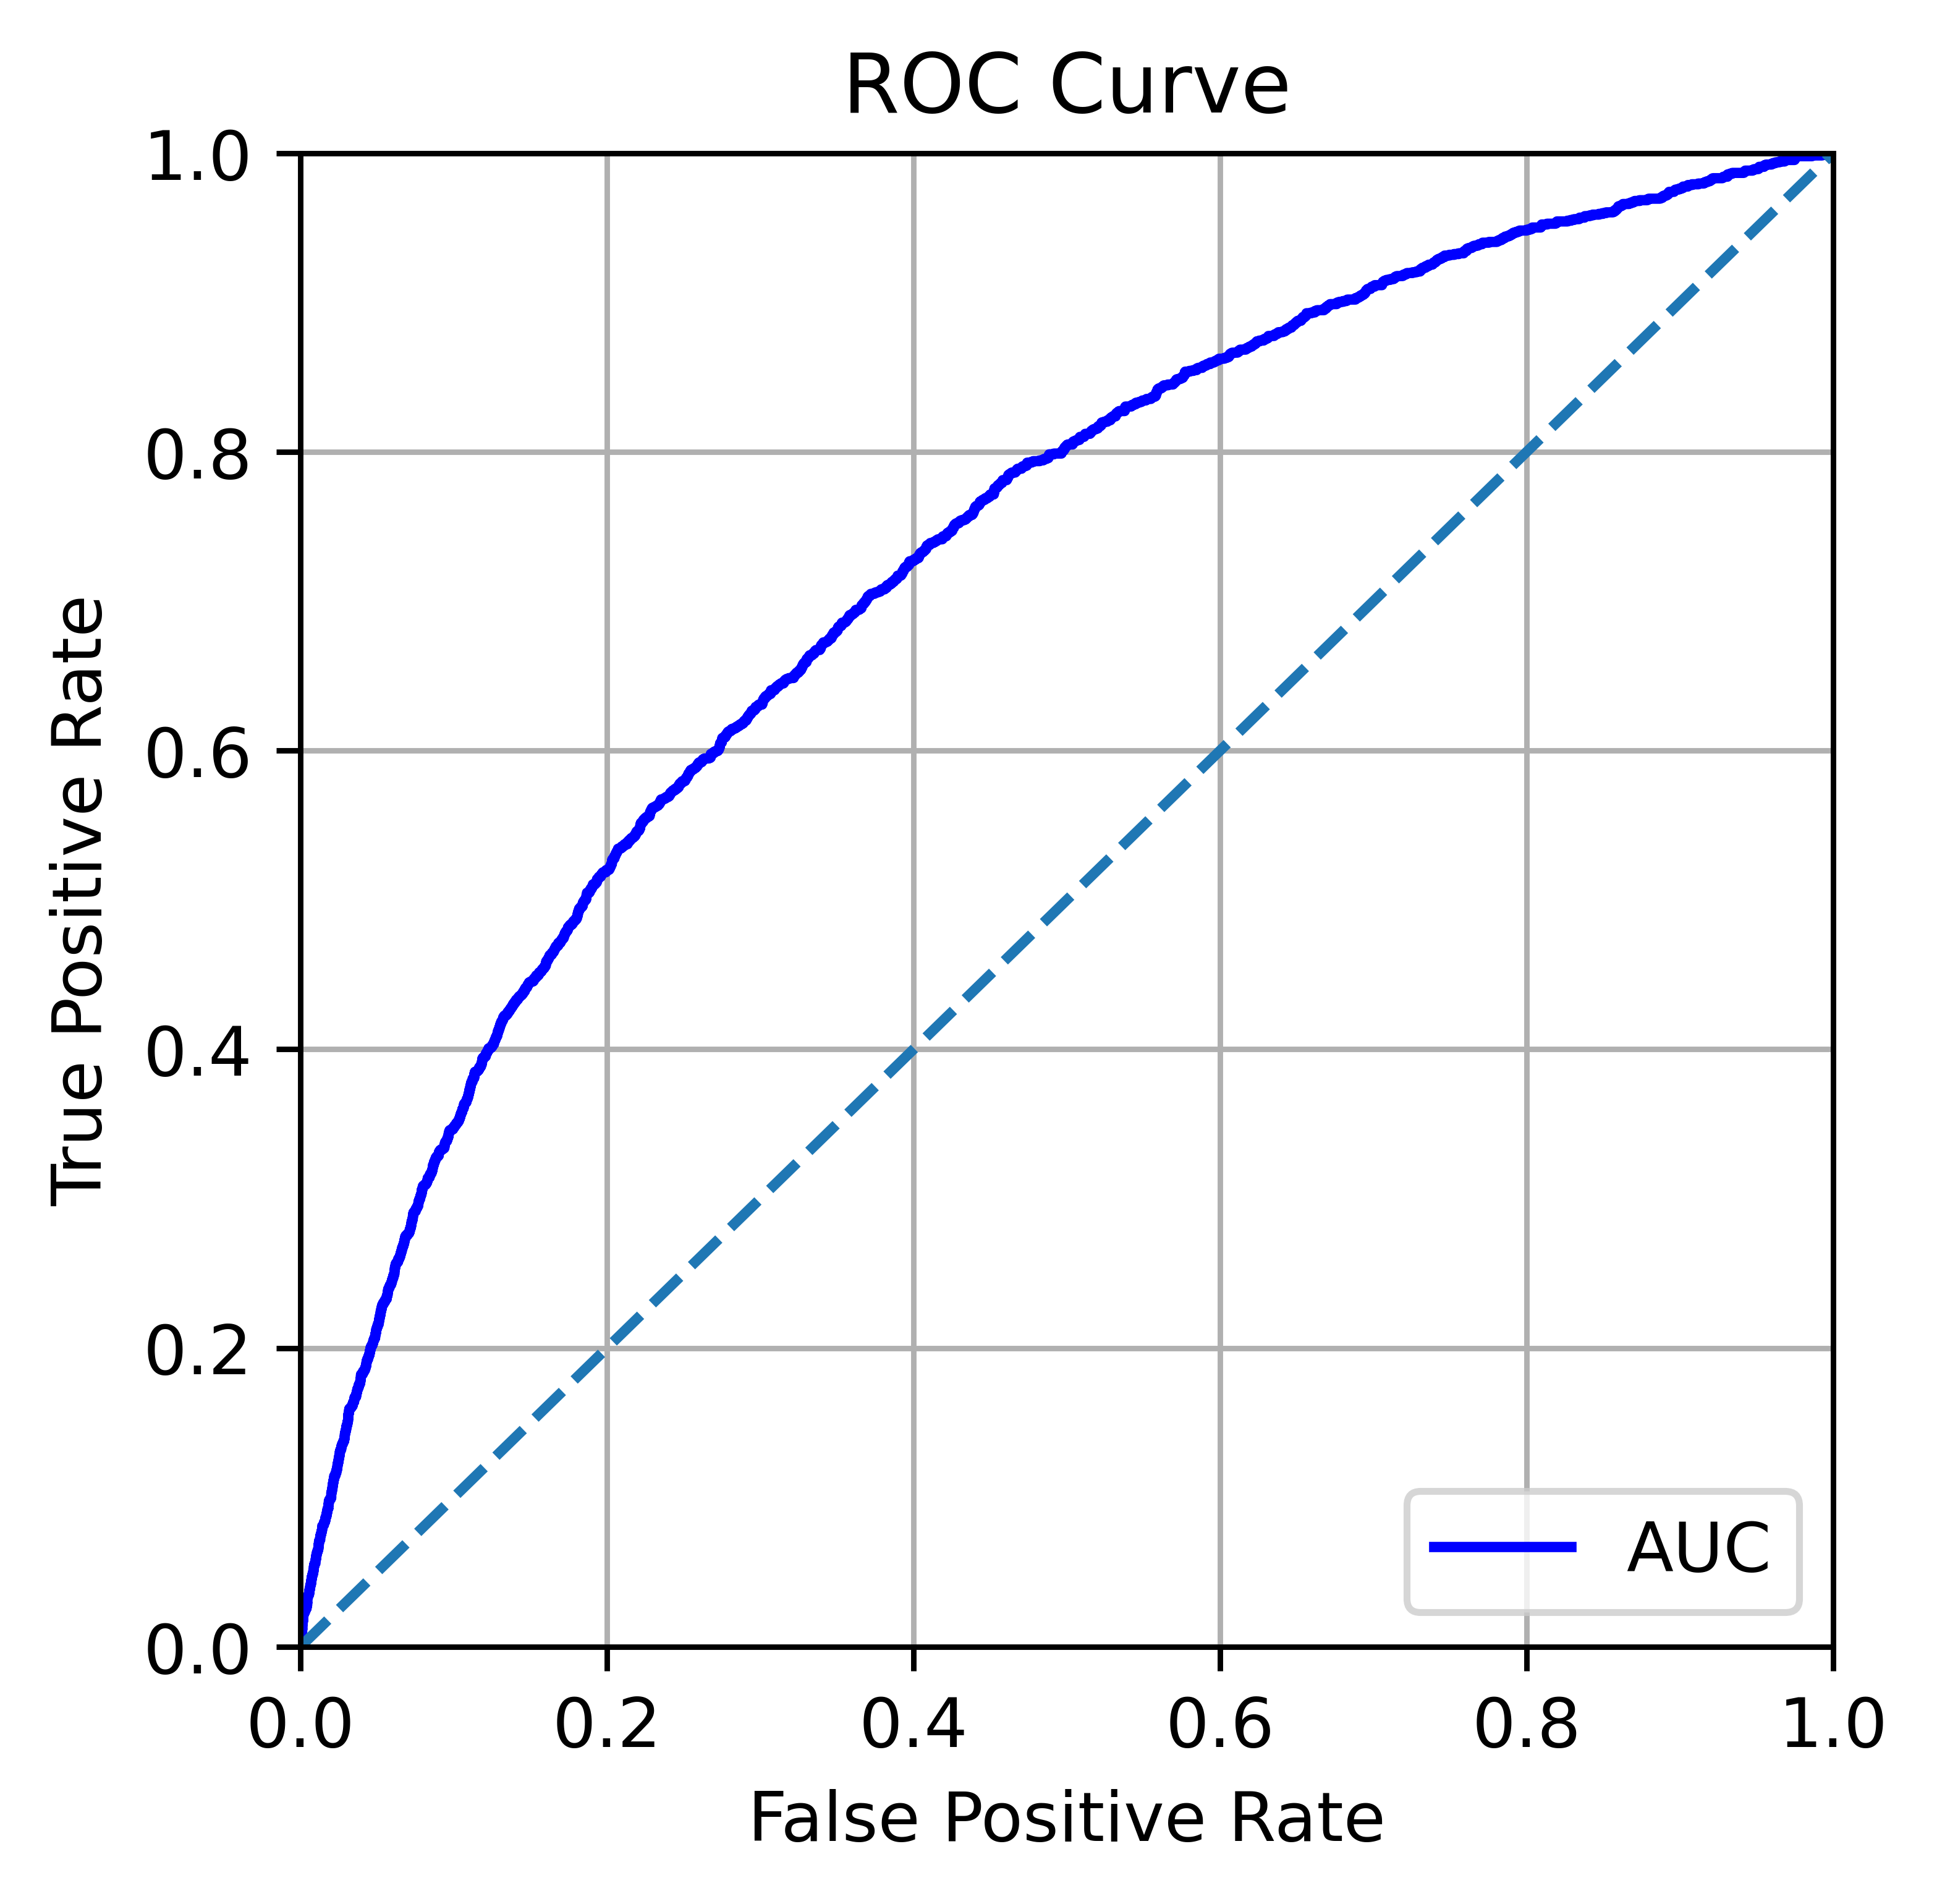

LogisticRegression(penalty='l1', solver='liblinear')

In [33]:
logistic(X_train,y_train,X_test,y_test)

# 5. Model ensemble

In [35]:
xgb_final = XGBClassifier(objective= 'binary:logistic', colsample_bytree=0.7,gamma=0.1, learning_rate=0.01, 
              max_depth=12,n_estimators=700, random_state=1245
                         ).fit(X_train,y_train)


C:\Users\krist\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
rfc_final = RandomForestClassifier(max_depth=14,  n_estimators=500, random_state=1245,criterion="entropy"
                         ).fit(X_train,y_train)


In [50]:
from sklearn.metrics import roc_auc_score

a= 0.5
y_pred = a*rfc_final.predict_proba(X_test)+ (1-a)*xgb_final.predict_proba(X_test)
em_test_auc = roc_auc_score(y_test, y_pred[:,1])
print(f'ensembled model test auc: {em_test_auc:.6f}')


ensembled model test auc: 0.781177
